# Installation

- Run these commands

    - git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git

    - cd Monk_Object_Detection/3_mxrcnn/installation

- Select the right requirements file and run

    - cat requirements_cuda10.1.txt | xargs -n 1 -L 1 pip install

In [ ]:
! git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git

In [ ]:
# For colab use the command below
#! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install


# For Local systems and cloud select the right CUDA version
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_cuda10.1.txt | xargs -n 1 -L 1 pip install

# DATA Conversion- Monk to COCO Format

## Required Dataset Directory Structure

    ./ (root_dir)
          |
          |------Document_Layout_Analysis (coco_dir) 
          |         |
          |         |---Images (img_dir)
          |         |----|
          |              |-------------------img1.jpg
          |              |-------------------img2.jpg
          |              |-------------------.........(and so on)
          |
          |
          |         |---annotations (anno_dir)
          |         |----|
          |              |--------------------instances_Images.json 
          |              |--------------------classes.txt
          
          
 - instances_Train.json -> In proper COCO format
 - classes.txt          -> A list of classes in alphabetical order

In [2]:
import os
import numpy as np 
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString
from tqdm import tqdm
import shutil
import json
import pandas as pd

In [3]:
root = "Document_Layout_Analysis";
img_dir = "Images/";
anno_file = "train_labels.csv";

In [4]:
dataset_path = root;
images_folder = root + "/" + img_dir;
annotations_path = root + "/annotations/";

In [5]:
if not os.path.isdir(annotations_path):
    os.mkdir(annotations_path)
    
input_images_folder = images_folder;
input_annotations_path = root + "/" + anno_file;

In [6]:
output_dataset_path = root;
output_image_folder = input_images_folder;
output_annotation_folder = annotations_path;

tmp = img_dir.replace("/", "");
output_annotation_file = output_annotation_folder + "/instances_" + tmp + ".json";
output_classes_file = output_annotation_folder + "/classes.txt";

In [7]:
if not os.path.isdir(output_annotation_folder):
    os.mkdir(output_annotation_folder);

In [8]:
df = pd.read_csv(input_annotations_path);
columns = df.columns
delimiter = " ";

In [9]:
list_dict = [];
anno = [];
for i in range(len(df)):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    for j in range(len(tmp)//5):
        label = tmp[j*5+4];
        if(label not in anno):
            anno.append(label);
    anno = sorted(anno)
    
for i in tqdm(range(len(anno))):
    tmp = {};
    tmp["supercategory"] = "master";
    tmp["id"] = i;
    tmp["name"] = anno[i];
    list_dict.append(tmp);

anno_f = open(output_classes_file, 'w');
for i in range(len(anno)):
    anno_f.write(anno[i] + "\n");
anno_f.close();

100%|██████████| 18/18 [00:00<00:00, 59966.22it/s]


In [10]:
coco_data = {};
coco_data["type"] = "instances";
coco_data["images"] = [];
coco_data["annotations"] = [];
coco_data["categories"] = list_dict;
image_id = 0;
annotation_id = 0;


for i in tqdm(range(len(df))):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    image_in_path = input_images_folder + "/" + img_name;
    img = cv2.imread(image_in_path, 1);
    h, w, c = img.shape;

    images_tmp = {};
    images_tmp["file_name"] = img_name;
    images_tmp["height"] = h;
    images_tmp["width"] = w;
    images_tmp["id"] = image_id;
    coco_data["images"].append(images_tmp);
    

    for j in range(len(tmp)//5):
        x1 = int(tmp[j*5+0]);
        y1 = int(tmp[j*5+1]);
        x2 = int(tmp[j*5+2]);
        y2 = int(tmp[j*5+3]);
        label = tmp[j*5+4];
        annotations_tmp = {};
        annotations_tmp["id"] = annotation_id;
        annotation_id += 1;
        annotations_tmp["image_id"] = image_id;
        annotations_tmp["segmentation"] = [];
        annotations_tmp["ignore"] = 0;
        annotations_tmp["area"] = (x2-x1)*(y2-y1);
        annotations_tmp["iscrowd"] = 0;
        annotations_tmp["bbox"] = [x1, y1, x2-x1, y2-y1];
        annotations_tmp["category_id"] = anno.index(label);

        coco_data["annotations"].append(annotations_tmp)
    image_id += 1;

outfile =  open(output_annotation_file, 'w');
json_str = json.dumps(coco_data, indent=4);
outfile.write(json_str);
outfile.close();

100%|██████████| 1783/1783 [02:18<00:00, 12.87it/s]


# Training

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")

In [2]:
from train_base import *

In [3]:
# Dataset params
root_dir = "./";
coco_dir = "Document_Layout_Analysis";
img_dir = "Images";

In [4]:
set_dataset_params(root_dir=root_dir, coco_dir=coco_dir, imageset=img_dir);

The model has been trained once for 3 epochs with 0.005 learning rate. The learning rate decay option in set_hyper_params decayed the learning rate to 0.0005 which is very slow. So the training was manually paused and resumed from epoch 3 for 4 more epochs.

In [5]:
# Model Type
set_model_params(model_name="vgg16", resume="trained_model/model_vgg16-0003.params", start_epoch=3);

In [6]:
#Hyperparameters
set_hyper_params(gpus="0", lr=0.001, epochs=10, batch_size=2);

In [7]:
set_output_params(log_interval=500, save_prefix="model_vgg16");

In [8]:
#Preprocessing image parameters(mean and std calculated in preprocessing notebook)
set_img_preproc_params(img_short_side=300, img_long_side=500, mean=(205.4947792530714, 210.0757122321346, 205.5501630335441), std=(0.2429826679074847, 0.24957906533432994, 0.2625039283385689));

In [9]:
#Initializing Parameters
initialize_rpn_params();
initialize_rcnn_params();

In [10]:
#Removing cache if any

In [11]:
if os.path.isdir("./cache/"):
    os.system("rm -r ./cache/")

In [12]:
#loading dataset
roidb = set_dataset();

INFO:root:computing cache ./cache/coco_Images_roidb.pkl


loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


INFO:root:saving cache ./cache/coco_Images_roidb.pkl
INFO:root:coco_Images num_images 1783
INFO:root:filter roidb: 1783 -> 1783
INFO:root:coco_Images append flipped images to roidb


In [13]:
#loading model
sym = set_network();

In [ ]:
train(sym, roidb);

INFO:root:max input shape
{'bbox_target': (2, 36, 31, 31),
 'bbox_weight': (2, 36, 31, 31),
 'data': (2, 3, 500, 500),
 'gt_boxes': (2, 100, 5),
 'im_info': (2, 3),
 'label': (2, 1, 279, 31)}
INFO:root:max output shape
{'bbox_loss_reshape_output': (2, 64, 76),
 'blockgrad0_output': (2, 64),
 'cls_prob_reshape_output': (2, 64, 19),
 'rpn_bbox_loss_output': (2, 36, 31, 31),
 'rpn_cls_prob_output': (2, 2, 279, 31)}
INFO:root:locking params
['conv1_1_weight',
 'conv1_1_bias',
 'conv1_2_weight',
 'conv1_2_bias',
 'conv2_1_weight',
 'conv2_1_bias',
 'conv2_2_weight',
 'conv2_2_bias',
 'conv3_1_weight',
 'conv3_1_bias',
 'conv3_2_weight',
 'conv3_2_bias',
 'conv3_3_weight',
 'conv3_3_bias',
 'conv4_1_weight',
 'conv4_1_bias',
 'conv4_2_weight',
 'conv4_2_bias',
 'conv4_3_weight',
 'conv4_3_bias']
INFO:root:lr 0.001000 lr_epoch_diff [4] lr_iters [7132]


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Epoch[3] Batch [0-500]	Speed: 1.54 samples/sec	RPNAcc=0.806442	RPNLogLoss=0.481186	RPNL1Loss=0.616389	RCNNAcc=0.750390	RCNNLogLoss=0.891296	RCNNL1Loss=2.191731
INFO:root:Epoch[3] Batch [0-1000]	Speed: 1.43 samples/sec	RPNAcc=0.806581	RPNLogLoss=0.482737	RPNL1Loss=0.622351	RCNNAcc=0.750687	RCNNLogLoss=0.900926	RCNNL1Loss=2.353992
INFO:root:Epoch[3] Batch [0-1500]	Speed: 1.34 samples/sec	RPNAcc=0.806967	RPNLogLoss=0.482103	RPNL1Loss=0.623363	RCNNAcc=0.750588	RCNNLogLoss=0.901892	RCNNL1Loss=2.291008
INFO:root:Epoch[3] Train-RPNAcc=0.807714
INFO:root:Epoch[3] Train-RPNLogLoss=0.481312
INFO:root:Epoch[3] Train-RPNL1Loss=0.624686
INFO:root:Epoch[3] Train-RCNNAcc=0.750635
INFO:root:Epoch[3] Train-RCNNLogLoss=0.900800
INFO:root:Epoch[3] Train-RCNNL1Loss=2.274734
INFO:root:Epoch[3] Time cost=2535.767
INFO:root:Saved checkpoint to "trained_model/model_vgg16-0004.params"
INFO:root:Epoch[4] Batch [0-500]	Speed: 1.30 samples/sec	RPNAcc=0.806442	RPNLogLoss=0.480890	RPNL1Loss=0.615419	RCNNA

# Inference

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")

In [2]:
from infer_base import *

In [3]:
class_file = set_class_list("./Document_Layout_Analysis/annotations/classes.txt");

In [30]:
#Model - Select the model as per number of iterations it has been trained for
set_model_params(model_name="vgg16", model_path="trained_model/model_vgg16-0005.params");

In [31]:
set_hyper_params(gpus="0", batch_size=1);

In [32]:
set_img_preproc_params(img_short_side=300, img_long_side=500, mean=(205.4947792530714, 210.0757122321346, 205.5501630335441), std=(0.2429826679074847, 0.24957906533432994, 0.2625039283385689));

In [33]:
initialize_rpn_params();

In [34]:
initialize_rcnn_params();

In [35]:
sym = set_network();
mod = load_model(sym);

paragraph
 0.21243120729923248 [0.0, 3197.8122880058686, 2433.8600551263585, 3263.028176934165]
paragraph
 0.21243120729923248 [0.0, 3256.4996324747717, 2433.8600551263585, 3264.1400739320056]
['paragraph\n', 0.21243120729923248, [0.0, 3197.8122880058686, 2433.8600551263585, 3263.028176934165]]


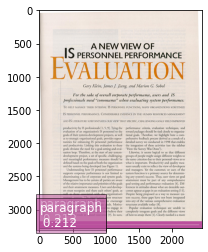

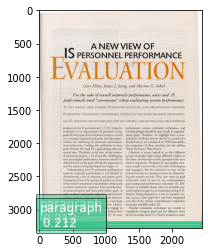

In [36]:
set_output_params(vis_thresh=0.2, vis=True)
Infer("PRImA_Layout_Analysis_Dataset/Test_Images/test1.jpg", mod);

paragraph
 0.21243120729923248 [0.0, 3236.822549667, 2366.0866290587323, 3244.4666150972585]
paragraph
 0.21243120729923248 [0.0, 3109.825964568043, 2366.0866290587323, 3242.338071429919]
['paragraph\n', 0.21243120729923248, [0.0, 3236.822549667, 2366.0866290587323, 3244.4666150972585]]


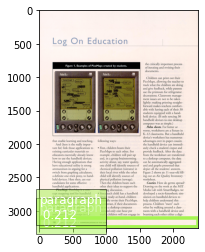

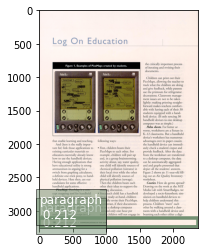

In [37]:
set_output_params(vis_thresh=0.2, vis=True)
Infer("PRImA_Layout_Analysis_Dataset/Test_Images/test2.jpg", mod);

paragraph
 0.2041110396385193 [0.0, 3448.8014077410057, 2422.896624906404, 3508.055547955072]
paragraph
 0.2041110396385193 [0.0, 3501.083337992235, 2422.896624906404, 3508.7432728577696]
['paragraph\n', 0.2041110396385193, [0.0, 3448.8014077410057, 2422.896624906404, 3508.055547955072]]


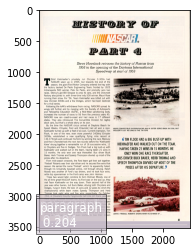

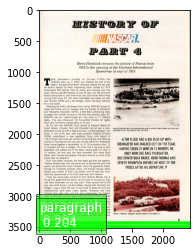

In [19]:
set_output_params(vis_thresh=0.2, vis=True)
Infer("PRImA_Layout_Analysis_Dataset/Test_Images/test3.jpg", mod);

As it can be seen, the model is performing very poorly on test images. The reason for this issue is still unknown (can be issue in conversion to COCO format, pause and resume issue or backend issue) as the model was taking a lot of time in training (45 minutes per epoch) and I couldn't explore much due to time constraints.